# Muckrock Requests Data Analysis #

Included below is the code used to clean and analyze the Muckrock Request data as well as the preview of the analysis results. Full results are exported to .csv files and moved to the "updated analysis results" folder to prevent the notebook from being clogged.

The .to_csv lines of code have been commented out as a new csv file doesn't need to be generated everytime. If changes have been made, uncomment the lines of code and rerun the notebook to produce a new csv file.

In [28]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

#prevents warnings from being printed
import warnings
warnings.filterwarnings('ignore')

In [29]:
requests = pd.read_csv('requests.csv')
requests

,User,Title,Status,URL,Jurisdiction,Jurisdiction ID,Jurisdiction Level,Jurisdiction State,Agency,Agency ID,...,Tracking Number,Embargo,Days since submitted,Days since updated,Projects,Tags,Price,Date Submitted,Date Due,Date Done
0,PNWPals,02.10.18 IAP and OPAAR,No Responsive Documents,https://www.muckrock.com/foi/seattle-69/021018...,Seattle,69,Local,Washington,Seattle Police Department,227,...,P024303-022618,False,1303.0,1240,NaN,NaN,0.0,2018-02-23 05:00:00+00:00,2018-03-02,2018-04-27 00:00:00+00:00
1,Woods,0215 Memphis - Kristen Smith,No Responsive Documents,https://www.muckrock.com/foi/memphis-319/0215-...,Memphis,319,Local,Tennessee,University Of Memphis - Memphis,15225,...,NaN,False,214.0,169,NaN,NaN,0.0,2021-02-16 16:41:44.333874+00:00,2021-02-25,2021-04-02 17:57:40.391587+00:00
2,null_name,02/29/16 - SLCPD Abdi Mohamed Protest Action P...,No Responsive Documents,https://www.muckrock.com/foi/salt-lake-city-35...,Salt Lake City,359,Local,Utah,Salt Lake City Police Department,4223,...,NaN,False,2010.0,1986,A Protest Project,NaN,0.0,2016-03-18 04:00:00+00:00,2016-04-01,2016-04-11 00:00:00+00:00
3,MichelleMalkin,#04-5812 public records request,Completed,https://www.muckrock.com/foi/midwest-city-2705...,Midwest City,27056,Local,Oklahoma,Midwest City Police Department,12077,...,NaN,False,957.0,927,NaN,NaN,0.0,2019-02-04 18:58:22.499172+00:00,NaN,2019-03-06 16:04:14.465141+00:00
4,EmmaBest,100-18762 Harry Hay,Awaiting Response,https://www.muckrock.com/foi/united-states-of-...,United States of America,10,Federal,United States of America,Federal Bureau of Investigation,10,...,NaN,False,1115.0,934,Freedom of LGBTQIA+ Information,NaN,0.0,2018-08-30 12:05:11.174398+00:00,2018-09-28,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72497,EmmaBest,ZTE phone backdoor (Department of Homeland Sec...,Awaiting Acknowledgement,https://www.muckrock.com/foi/united-states-of-...,United States of America,10,Federal,United States of America,Department of Homeland Security,9,...,NaN,False,836.0,563,Hacking History,NaN,0.0,2019-06-05 09:44:15.782868+00:00,2019-07-03,NaN
72498,EmmaBest,ZTE phone backdoor (Federal Bureau of Investig...,No Responsive Documents,https://www.muckrock.com/foi/united-states-of-...,United States of America,10,Federal,United States of America,Federal Bureau of Investigation,10,...,"1438962-000, DOJ-AP-2019-006962",False,836.0,79,Hacking History,NaN,0.0,2019-06-05 09:44:15.782868+00:00,2019-07-03,2021-07-01 16:28:57.662780+00:00
72499,lukestoddardnathan,Zucker medmar emails,Awaiting Response,https://www.muckrock.com/foi/new-york-16/zucke...,New York,16,State,New York,New York State Department of Health,4384,...,NaN,False,1440.0,1418,NaN,NaN,0.0,2017-10-09 04:00:00+00:00,2017-10-16,NaN
72500,beryllipton,"""Zumba"" emails between Kennebunk PD and Maine ...",Payment Required,https://www.muckrock.com/foi/kennebunk-6232/zu...,Kennebunk,6232,Local,Maine,Kennebunk Police Department,4247,...,NaN,False,2525.0,2481,NaN,NaN,210.0,2014-10-20 04:00:00+00:00,NaN,NaN


## How many requests do law enforcement agencies receive vs. non-law enforcement agencies? ##

Law enforcement requests were separated by checking if the Agency name included "police", "sheriff", or "safety". While this doesn't ensure that every law enforcement agency was included, it should encapsulate most of them. 

In [30]:
#pull out federal
requests = requests[requests['Jurisdiction Level'] != 'Federal']
print("Number of requests to State and Local law enforcement:", len(requests))

Number of requests to State and Local law enforcement: 46300


In [31]:
# split into police and non-police requests
police_reqs = requests[requests['Agency'].str.contains("(?i)police|sheriff|public safety", case = False)]
non_police_reqs = requests[~requests['Agency'].str.contains("(?i)police|sheriff|public safety", case = False)]

In [32]:
#police_reqs.to_csv('Police Requests.csv', index = False)
#non_police_reqs.to_csv('Non Police Requests.csv', index = False)

In [33]:
# ensure that length of both tables is equal to the original
len(police_reqs) + len(non_police_reqs) == len(requests)

True

In [34]:
print("Number of requests received by law enforcement agencies: ", len(police_reqs),
      "\nNumber of requests received by non-law enforcement agencies: ", len(non_police_reqs))

Number of requests received by law enforcement agencies:  21342 
Number of requests received by non-law enforcement agencies:  24958


## How many requests did each law enforcement agency receive? ##

Included below is a small preview of the the analysis results sorted by most requests received. The full table is exported to a .csv file.

In [35]:
by_agency = police_reqs[['Agency']].value_counts().to_frame().rename(columns = {0: "Requests Received"}).reset_index()
by_agency.head()

,Agency,Requests Received
0,New York City Police Department,556
1,Chicago Police Department,508
2,Boston Police Department,369
3,Seattle Police Department,326
4,Massachusetts State Police,241


In [36]:
one_req = len(by_agency[by_agency['Requests Received'] == 1])
tot = len(by_agency)

In [37]:
print("Number of agencies that only had one request: ", one_req, "\nTotal number of agencies: ", tot)

Number of agencies that only had one request:  1531 
Total number of agencies:  3511


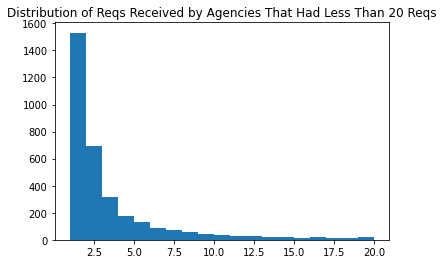

In [38]:
less_than20 = by_agency[by_agency['Requests Received'] <= 20]
plt.title('Distribution of Reqs Received by Agencies That Had Less Than 20 Reqs')
plt.hist(less_than20['Requests Received'], bins = 19);

## How many requests were received by law enforcement agencies in each jurisdiction level? ##

In [39]:
by_jurlevel = police_reqs["Jurisdiction Level"].value_counts().to_frame().reset_index().rename(columns = {'index': 'Jurisdiction Level', 'Jurisdiction Level': 'Requests Received'})
by_jurlevel


,Jurisdiction Level,Requests Received
0,Local,19063
1,State,2279


## How quickly on average do law enforcement agencies respond to requests versus non-law enforcement agencies?

The issue with the dataset is that there are some entries that never had the "Date Done" column filled out or there were errors with the entry where the date was entered incorrectly. Errors include:
- Completing the entry on the same day but instead of entering the "Date Done" to be the next day, the same date was entered leading to a negtive time difference. 
- Date is just entered incorrectly. 

For a simple fix, the ```replaceNegatives``` function is used to change the "Days Till Completion" value to be positive. 
Next, for calculating the mean, entries without a Date Done entry are excluded as well as entries where the dates were entered incorrectly.

In [40]:
def replaceNegatives(x):
    """
        x: input, a timedelta object
        output: the same timedelta object or the adjusted timedelta object
        
        The completion date for some entries were inputted to be the same date instead of the next date which resulted in a negative
        difference between the Date Done and the Date Submitted. Adding 1 to the time changes the time difference from being 
        "-1 days and XX hours" to be "0 days and XX hours".
    """

    if x.days == -1:
        x += timedelta(days = 1)
        return x
    return x

In [41]:
#convert dates to a datetime object for easy manipulation
police_reqs['Date Submitted'] = pd.to_datetime(police_reqs['Date Submitted'])
police_reqs['Date Due'] = pd.to_datetime(police_reqs['Date Due'])
police_reqs['Date Done'] = pd.to_datetime(police_reqs['Date Done'])

non_police_reqs['Date Submitted'] = pd.to_datetime(non_police_reqs['Date Submitted'])
non_police_reqs['Date Due'] = pd.to_datetime(non_police_reqs['Date Due'])
non_police_reqs['Date Done'] = pd.to_datetime(non_police_reqs['Date Done'])

In [42]:
#find time it took for agency to complete request
police_reqs['Days Till Completion'] = police_reqs['Date Done'] - police_reqs['Date Submitted']
non_police_reqs['Days Till Completion'] = non_police_reqs['Date Done'] - non_police_reqs['Date Submitted']

In [43]:
# remove null values: entries where "Date Done" was never entered
police_completed = police_reqs[~pd.isnull(police_reqs['Days Till Completion'])]
non_police_completed = non_police_reqs[~pd.isnull(non_police_reqs['Days Till Completion'])]

# exclude entries where the difference in time was less than -1
police_completed = police_completed[police_completed['Days Till Completion'] >= timedelta(days = -1)]
non_police_completed = non_police_completed[non_police_completed['Days Till Completion'] >= timedelta(days = -1)]

#apply function to adjust for -1 day differences
police_completed['Days Till Completion'] = police_completed['Days Till Completion'].apply(replaceNegatives)
non_police_completed['Days Till Completion'] = non_police_completed['Days Till Completion'].apply(replaceNegatives)

In [44]:
#calculate mean
non_police_time = np.mean(non_police_completed['Days Till Completion'])
police_time = np.mean(police_completed['Days Till Completion'])

#calculate proportion of removed entries
prop_nonresponse_police = 1 - len(police_completed)/len(police_reqs)
prop_nonresponse_nonpolice = 1 - len(non_police_completed)/len(non_police_reqs)

In [45]:
print("Law enforcement response time to requests: ", police_time.round('1min') ,"\nNon-Law Enforcement response time: ", 
      non_police_time.round('1min'))
print("\nMeans calculated with nonresponse and incorrect entries omitted. \nProportion of omitted entries for police records: ", 
      round(prop_nonresponse_police, 4), "\nProportion of omitted non-police records: ", round(prop_nonresponse_nonpolice, 4))

Law enforcement response time to requests:  96 days 16:12:00 
Non-Law Enforcement response time:  75 days 17:37:00

Means calculated with nonresponse and incorrect entries omitted. 
Proportion of omitted entries for police records:  0.3299 
Proportion of omitted non-police records:  0.3181


## How quickly on average does each individual law enforcement agency respond to requests? 

In [46]:
avg_time = police_completed.groupby('Agency').agg({'Days Till Completion': pd.Series.mean}).reset_index().rename(
    columns = {'Days Till Completion': 'Avg Days Till Completion'})

#first 5 records, check csv for full list
avg_time.head()

,Agency,Avg Days Till Completion
0,Abbevile Police Department,31 days 20:00:00
1,Abbeville Police Department,97 days 20:37:43.811949
2,Aberdeen Police Department,30 days 19:03:00.422427250
3,Abilene Texas Police Department,252 days 20:49:24.204696500
4,Abington Police Department,19 days 07:08:21.447689111


Filtering the table for only agencies that have at least 25 requests:

In [47]:
over25 = by_agency[by_agency['Requests Received'] >= 25]
filtered_over25 = police_completed[police_completed['Agency'].isin(over25['Agency'])]

avg_time_over25 = filtered_over25.groupby('Agency').agg({'Days Till Completion': pd.Series.mean}).reset_index().rename(
    columns = {'Days Till Completion': 'Avg Days Till Completion'})
avg_time_over25.head()

,Agency,Avg Days Till Completion
0,Alameda County Sheriff's Office,146 days 05:10:00.590807542
1,Albuquerque Police Department,420 days 11:47:10.016993056
2,Arlington Police Department,125 days 17:40:15.756569502
3,Atlanta Police Department,20 days 19:58:36.303734830
4,Austin Police Department,64 days 17:25:13.569968257


## Percentage of Requests under Each Status ##

A column for the total number of requests has been added. The rest of the values show the proportion of requests that are under each status rounded to 4 decimal places if necessary. The table has been sorted alphabetically.

There are some agencies that don't have many requests so the rates can be quite misleading if only sorted by any of the statuses. So the tables have been filtered for only those agencies that have at least 50 agencies before sorting by the Completed rate.

### For Law Enforcement ###

In [48]:
police_status = police_reqs.pivot_table(columns = 'Status', index = 'Agency', aggfunc = 'size', fill_value = 0)
police_status['Total Number of Requests'] = police_status.sum(axis=1)
police_status_over50 = police_status[police_status['Total Number of Requests'] >= 50]

for col in police_status_over50.columns:
    if col != "Total Number of Requests":
        police_status_over50[col] = police_status_over50[col]/police_status_over50['Total Number of Requests']*100
police_status_over50 = police_status_over50.round(4)

police_status_over50 = police_status_over50.sort_values('Completed', ascending = False)
police_status_over50.head()

Status,Awaiting Acknowledgement,Awaiting Appeal,Awaiting Response,Completed,Fix Required,In Litigation,No Responsive Documents,Partially Completed,Payment Required,Processing,Rejected,Withdrawn,Total Number of Requests
Agency,,,,,,,,,,,,,
Evanston Police Department,0.0000,0.0000,0.0000,67.8571,1.7857,0.0,14.2857,0.0000,0.0000,0.0,10.7143,5.3571,56
Orange County Sheriff's Office,1.3333,0.0000,4.0000,58.6667,8.0000,0.0,18.6667,2.6667,2.6667,0.0,1.3333,2.6667,75
San Diego Police Department,0.0000,1.9802,0.9901,57.4257,3.9604,0.0,24.7525,1.9802,0.0000,0.0,6.9307,1.9802,101
Buffalo Police Department,0.0000,0.0000,3.3333,53.3333,5.0000,0.0,30.0000,0.0000,5.0000,0.0,3.3333,0.0000,60
Columbus Division of Police,2.1053,0.0000,2.1053,52.6316,11.5789,0.0,24.2105,1.0526,2.1053,0.0,2.1053,2.1053,95


### For Non-Law Enforcement ###

In [49]:
non_police_status = non_police_reqs.pivot_table(columns = 'Status', index = 'Agency', aggfunc = 'size', fill_value = 0)
non_police_status['Total Number of Requests'] = non_police_status.sum(axis=1)
nonpolice_status_over50 = non_police_status[non_police_status['Total Number of Requests'] >= 50]

for col in nonpolice_status_over50.columns:
    if col != "Total Number of Requests":
        nonpolice_status_over50[col] = nonpolice_status_over50[col]/nonpolice_status_over50['Total Number of Requests']*100
nonpolice_status_over50 = nonpolice_status_over50.round(4)

nonpolice_status_over50 = nonpolice_status_over50.sort_values('Completed', ascending = False)
nonpolice_status_over50.head()

Status,Awaiting Acknowledgement,Awaiting Appeal,Awaiting Response,Completed,Fix Required,In Litigation,No Responsive Documents,Partially Completed,Payment Required,Processing,Rejected,Withdrawn,Total Number of Requests
Agency,,,,,,,,,,,,,
Central Puget Sound Regional Transit Authority,0.0000,0.0000,1.8519,81.4815,0.0000,0.0,7.4074,0.0000,0.0000,0.0,5.5556,3.7037,54
Washington State Patrol,0.0000,0.0000,3.7736,60.3774,1.8868,0.0,18.8679,1.8868,1.8868,0.0,5.6604,5.6604,53
Empire State Development,0.0000,0.0000,0.0000,60.0000,6.0000,0.0,14.0000,4.0000,0.0000,0.0,16.0000,0.0000,50
Secretary of State,2.4096,1.2048,1.2048,59.0361,2.4096,0.0,14.4578,1.2048,2.4096,0.0,4.8193,10.8434,83
Charlottesville City Manager,0.0000,0.0000,0.0000,54.3860,10.5263,0.0,10.5263,0.0000,0.0000,0.0,17.5439,7.0175,57


## State Level Differences ##
### Status Distribution by State for Police/LawEnf ###

In [50]:
police_state_data = pd.DataFrame()

for state in police_reqs["Jurisdiction State"].unique():
    state_only = police_reqs.loc[police_reqs["Jurisdiction State"].str.contains(state, case=False)]
    state_array = state_only["Status"].value_counts()
    police_state_data [state] = round(state_array*100/sum(state_array),2)
    
police_state_data ["Variation between Max and Min"] = police_state_data .max(axis=1) - police_state_data .min(axis=1)
police_state_data = police_state_data.transpose()
police_state_data.index.names = ["State"]
police_state_data = police_state_data.fillna(0)

police_state_data.head()

,Completed,No Responsive Documents,Awaiting Response,Payment Required,Fix Required,Rejected,Withdrawn,Partially Completed,Awaiting Acknowledgement,Awaiting Appeal,In Litigation
State,,,,,,,,,,,
Washington,37.38,19.47,10.70,8.41,7.81,6.61,4.93,3.37,0.84,0.36,0.12
Utah,27.34,35.94,3.91,3.12,10.16,6.25,8.59,0.78,3.91,0.00,0.00
Oklahoma,44.12,31.18,2.94,2.35,7.06,5.88,1.18,1.76,1.76,1.18,0.00
Massachusetts,32.69,29.53,3.79,3.40,4.03,9.73,9.78,1.87,4.31,0.62,0.14
Illinois,54.07,20.53,4.78,0.09,6.64,6.46,3.10,1.24,1.86,0.80,0.44


### Status Distribution by State for non_police ###

In [51]:
non_police_state_data = pd.DataFrame()

for state in non_police_reqs["Jurisdiction State"].unique():
    state_only = non_police_reqs.loc[non_police_reqs["Jurisdiction State"].str.contains(state, case=False)]
    
    state_array = state_only["Status"].value_counts()
    non_police_state_data[state] = round(state_array*100/sum(state_array),2)
    
non_police_state_data["Variation between Max and Min"] = non_police_state_data.max(axis=1) - non_police_state_data.min(axis=1)
non_police_state_data = non_police_state_data.transpose()
non_police_state_data.index.names = ["State"]
non_police_state_data.sort_values(by="Completed").head()
non_police_state_data = non_police_state_data.fillna(0)

non_police_state_data.head()

,Completed,Rejected,Withdrawn,No Responsive Documents,Fix Required,Awaiting Acknowledgement,Awaiting Response,Payment Required,Partially Completed
State,,,,,,,,,
Tennessee,30.72,23.79,13.39,12.93,10.62,4.85,2.31,1.15,0.23
New York,44.69,13.01,4.87,21.15,4.41,2.33,7.15,0.62,0.93
Illinois,47.97,6.92,7.03,20.75,8.89,3.62,2.52,0.11,0.55
Alabama,29.75,12.56,32.07,9.75,4.46,5.29,0.99,1.65,3.31
Alaska,30.19,8.18,3.77,20.75,10.69,8.18,11.32,5.66,1.26


## Difference in Status Distribution between police and non police
***Important*** 
Differences calculated as police - non_police <br>
***Positive***: Police have higher rate of completion/rejection than non-police
***Negative***: Police have lower rate of completion/rejection


So negative completion and positive rejection would be in line with the "transparency exception" hypothesis

In [52]:
combined_state = police_state_data.merge(non_police_state_data, on="State", suffixes=('_Police', '_nonLE'))[["Completed_Police","Completed_nonLE",
                                                                                      "Rejected_Police","Rejected_nonLE"]]
                                                                                                                                                                    
                                                                                     
combined_state["Completed Diff"]= combined_state["Completed_Police"] - combined_state["Completed_nonLE"]


combined_state["Rejected Diff"]= combined_state["Rejected_Police"] - combined_state["Rejected_nonLE"]

combined_state.iloc[:,[0,1,4,2,3,5]]

combined_state.loc[:,["Completed Diff", "Rejected Diff"]].head()

,Completed Diff,Rejected Diff
State,,
Washington,-20.41,2.84
Utah,-9.34,-4.30
Oklahoma,6.85,-3.67
Massachusetts,-0.18,7.38
Illinois,6.10,-0.46


## Requests Received by Each State ##

In [53]:
police_req_count_state = police_reqs.groupby("Jurisdiction State")[["URL"]].count()
police_req_count_state.index.names = ["State"]

non_police_req_count_state =non_police_reqs.groupby("Jurisdiction State")[["URL"]].count()
non_police_req_count_state.index.names = ["State"]

combined_count_by_state = police_req_count_state.merge(non_police_req_count_state, on="State", suffixes=('_Police', '_NonPolice')).rename(
columns={"URL_Police": "Num Police Reqs", "URL_NonPolice": "Num Non-Police Reqs"})

combined_count_by_state["Proportion Police Requests"] = combined_count_by_state["Num Police Reqs"] /sum(
    combined_count_by_state["Num Police Reqs"],combined_count_by_state["Num Non-Police Reqs"])

combined_count_by_state.sort_values(by="Proportion Police Requests", ascending=False).head()

,Num Police Reqs,Num Non-Police Reqs,Proportion Police Requests
State,,,
California,3167,2935,0.130453
Massachusetts,2086,4347,0.081202
New York,1657,1929,0.071205
Texas,1266,903,0.056912
Illinois,1130,911,0.050780


<h1> <font: red>Difference in Response (Completion) Times Between States

### Average completion time per state—police requests

In [54]:
police_state_time_data = pd.DataFrame()

for state in police_reqs["Jurisdiction State"].unique():
    mean_response = police_reqs.loc[police_reqs["Jurisdiction State"]==state][["Days Till Completion"]].mean()
    police_state_time_data[state] = mean_response
police_state_time_data =police_state_time_data.transpose()
police_state_time_data.rename(columns={"Days Till Completion":"Mean Time to Complete: Police"},inplace=True)
police_state_time_data.sort_values(by="Mean Time to Complete: Police").head()
police_state_time_data.index.names = ["State"]

police_state_time_data.sort_values(by="Mean Time to Complete: Police").head()

,Mean Time to Complete: Police
State,
Rhode Island,21 days 18:08:24.776280898
Maine,32 days 00:50:06.525581246
Vermont,35 days 11:43:49.224016549
Idaho,39 days 01:56:27.168339400
Kentucky,44 days 09:22:33.108131857


### Average completion time per state—nonpolice requests


In [55]:
non_police_state_time_data = pd.DataFrame()

for state in non_police_reqs["Jurisdiction State"].unique():
    mean_response = non_police_reqs.loc[non_police_reqs["Jurisdiction State"]==state][["Days Till Completion"]].mean()
    non_police_state_time_data[state] = mean_response

    
non_police_state_time_data=non_police_state_time_data.transpose()
non_police_state_time_data.rename(columns={"Days Till Completion":"Mean Time to Complete: Non Police"},inplace=True)
non_police_state_time_data.index.names = ["State"]

non_police_state_time_data.sort_values(by="Mean Time to Complete: Non Police").head()


,Mean Time to Complete: Non Police
State,
Rhode Island,19 days 04:17:56.258007758
North Dakota,28 days 05:51:31.396273591
West Virginia,30 days 07:53:52.901694186
Iowa,41 days 10:47:39.644742544
Guam,42 days 05:50:45.400697333


### Now add to our existing combined dataset (which compares completion rates)  to assess difference in mean times across states
Positive indicates police take longer. Negative indicates police take shorter. 

In [56]:
combined_state= combined_state.merge(non_police_state_time_data, on="State").merge(police_state_time_data, on="State")

#find difference in mean times, rounded to 1 day
combined_state["Mean Time Diff"] = (combined_state["Mean Time to Complete: Police"] - combined_state["Mean Time to Complete: Non Police"]).round("1d")

diff_in_compl_rej_mean_time = combined_state[["Completed Diff", "Rejected Diff", "Mean Time Diff"]]
diff_in_compl_rej_mean_time


,Completed Diff,Rejected Diff,Mean Time Diff
State,,,
Washington,-20.41,2.84,-4 days
Utah,-9.34,-4.30,-19 days
Oklahoma,6.85,-3.67,7 days
Massachusetts,-0.18,7.38,78 days
Illinois,6.10,-0.46,-2 days
California,5.60,1.20,22 days
Arizona,-5.66,1.38,52 days
Georgia,10.40,-2.11,-36 days
Idaho,-3.96,-3.45,-5 days


In [57]:
#uncomment to reproduce csv files

"""
avg_time.to_csv('Avg Time of Response by Agency.csv')
avg_time_over25.to_csv('Avg Time of Response of Agencies with 25+ Reqs.csv')
diff_in_compl_rej_mean_time.to_csv("Difference in Rates and Times across States.csv")
combined_state.to_csv('Difference in Status Distribution.csv', index = False)
police_status_over50.to_csv('Law Enforcement- Proportion of Requests under Each Status.csv')
police_state_data.to_csv('Law Enforcement - Status Distribution by State.csv', index = False)
nonpolice_status_over50.to_csv('Non-Law Enforcement- Proportion of Requests under Each Status.csv')
non_police_state_data.to_csv('Non-Law Enforcement - Status Distribution by State.csv')
non_police_state_time_data.to_csv('Non-Police Reqs Avg Time per State.csv')
by_agency.to_csv('numRequests_byAgency.csv')
by_jurlevel.to_csv('numRequests_byJurisdiction.csv')
combined_count_by_state.to_csv('Requests Received by State.csv', index = False)
police_state_time_data.to_csv('Police Reqs Avg Time per State.csv', index = False)
""";

<h1> Some visualizations to illustrate differences in rejection/completion/response time BY STATE

### Positive indicates police take longer in that state or have a higher rate ###

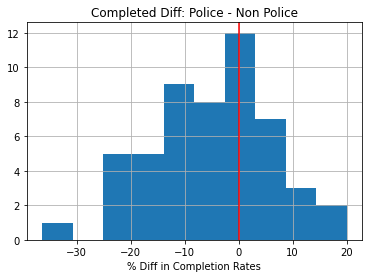

In [59]:
combined_state.hist("Completed Diff")
plt.title("Completed Diff: Police - Non Police")
plt.xlabel("% Diff in Completion Rates")
plt.axvline(0, color="red");

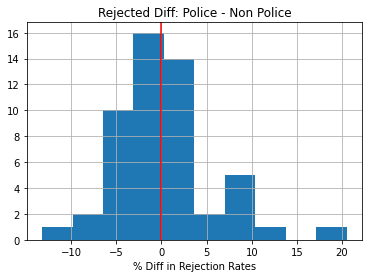

In [60]:
combined_state.hist("Rejected Diff")
plt.title("Rejected Diff: Police - Non Police")
plt.xlabel("% Diff in Rejection Rates")
plt.axvline(0, color="red");

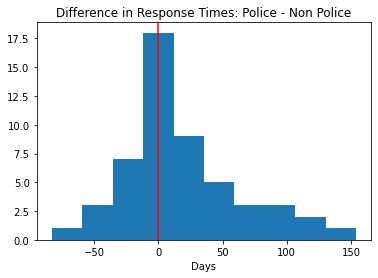

In [33]:
#time delta is hard to plot
days = []
for i in np.arange(len(combined_state["Mean Time Diff"])):
    days.append(combined_state["Mean Time Diff"][i].days)

plt.hist(days)
plt.axvline(0, color="red")
plt.xlabel("Days")
plt.title("Difference in Response Times: Police - Non Police");

## Text Analysis of Rejected Police Requests ##

In [34]:
pd.set_option('display.max_colwidth', None)

In [35]:
police_rej = police_reqs[(police_reqs['Status'] == 'Rejected') | (police_reqs['Status'] == 'Completed')]
police_rej['Requested Documents'] = police_rej['Requested Documents'].astype('str')
police_rej['Requested Documents'] = police_rej['Requested Documents'].str.lower()

In [36]:
len(police_rej['Requested Documents'])

10010

In [38]:
police_rej.columns

Index(['User', 'Title'], dtype='object')

In [48]:
police_rej = police_rej[['User', 'Title','Status', 'URL', 'Jurisdiction Level','Agency', 'Agency ID','Requested Documents','Date Submitted',
       'Date Due', 'Date Done', 'Days Till Completion']]

In [53]:
police_rej.head(3)

,User,Title,Status,URL,Jurisdiction Level,Agency,Agency ID,Requested Documents,Date Submitted,Date Due,Date Done,Days Till Completion
3,MichelleMalkin,#04-5812 public records request,Completed,https://www.muckrock.com/foi/midwest-city-27056/04-5812-public-records-request-68490/,Local,Midwest City Police Department,12077,"Any and all public records related to Incident #04-5812 (which was consolidated as part of Case Number CF-2004-4411), including initial offense reports, arrest records, jail registers, radio logs, crime summaries, and e-mail communications, as well as evidence inventory logs, property room general reports and collection forms, chain of custody forms, arrest reports, crime/incident reports and logs, and search warrants/affidavits.",2019-02-04 18:58:22.499172+00:00,NaT,2019-03-06 16:04:14.465141+00:00,29 days 21:05:51.965969
13,invisibleinstitute,1026812 documents,Completed,https://www.muckrock.com/foi/chicago-169/1026812-documents-34051/,Local,Chicago Police Department,503,"The following documents from the IAD investigation under the CR number 1026812, identified by their attachment number and description:\r\n\r\n6. Synoptic report of Sgt. Richard Downs\r\n19. Handwritten statement of Lt. John Brundage\r\n24-30. Interviews with Cmdr. Leo Schmitz, Lt. John Brundage, Sgt. Patrick Quinn, P.O. Brenda Gomez-Sanchez, P.P.O Milton Kinnison, and Sgt. Sean Ronan\r\n54-55. Results of email account searches of Cmdr. Leo Schmitz and Sgt. Sean Ronan\r\n56-59. All in-car camera footage\r\n78. Cmdr. Leo Schmitz's Blackberry log\r\n80. Cmdr. Leo Schmitz's response to OCIC report\r\n81. OCIC report retrieved from Sgt. Sean Ronan's email\r\n87. Cmdr. Leo Schmitz's disciplinary history\r\n89. Lt. John Brundage's disciplinary history",2017-02-26 05:00:00+00:00,2017-03-03,2017-03-20 00:00:00+00:00,21 days 19:00:00
16,invisibleinstitute,10/29 CR Request,Completed,https://www.muckrock.com/foi/chicago-169/1029-cr-request-82511/,Local,Chicago Police Department,503,"Copies of the attachment sheets, summary digest report, and any other final disposition documentation (e.g., an Administrative Closure order, mediation agreement, grievance decision or arbitration award) for each of the following CR investigations. If possible, please provide all files associated with each individual CR together in one PDF file per CR number.\r\n\r\n1059990\r\n290977\r\n1018421\r\n230550\r\n280421\r\n301052\r\n1075574\r\n272791\r\n274711\r\n270513",2019-10-29 19:47:12.607944+00:00,2019-11-06,2020-03-12 01:41:22.405932+00:00,134 days 05:54:09.797988


In [55]:
def words_in_texts(words, texts):
    '''
    Args:
        words (list): words to find
        texts (Series): strings to search in
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    
    indicator_array = [[w in text for w in words] for text in texts]
    return indicator_array

<AxesSubplot:xlabel='variable', ylabel='value'>

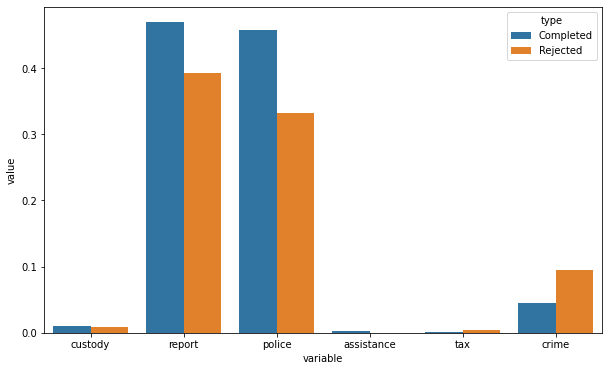

In [70]:
data = words_in_texts(['custody', 'report', 'police', 'assistance', 'tax', 'crime'], police_rej['Requested Documents'])
df = pd.DataFrame.from_records(data, columns = ['custody', 'report', 'police', 'assistance', 'tax', 'crime'])
df['type'] = police_rej['Status']
df['type'] = df['type'].replace({0: 'Completed', 1: 'Rejected'})
df = df.melt('type')
plt.figure(figsize = (10, 6))
sns.barplot(data = df, x = 'variable', y = 'value', hue = 'type', ci = None)